# Graphene

Exercise 1:
Repeat the explorations done with a square lattice: try to answer the following questions and justify your
sentences with graphs. To answer some of the questions you may have to explore the literature on graphene
(with no need to go very deep, a good review or a seminal paper shall bring you all the informations).

1) What is the upper limit of E which gives reasonable results? We will in the following restrict our study
to energies below this threshold.

2) What happens for E < 0? How does it compare to the case of a square lattice? Which property of
graphene does it underline?

3) How would you qualify the way transmission evolves with energy in the low density limit (the average evolution, not its
discretization)? How does it compare to the square lattice? Which property of graphene does it underline?

4) Focus on the very low energy limit of the dispersion relation, where discrete steps can be observed.
Comment their spacing and compare with the square lattice. Which property of graphene does it underline?

In [38]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import numpy as np
import math
from math import atan2, pi, sqrt, cos, sin
from cmath import exp
from types import SimpleNamespace
import matplotlib
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 5,5

In [39]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

In [98]:
def onsite(site):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    
    """
    (x, y) = site.pos
    d = y * np.cos(90) + x * np.sin(90)
    return pot * np.tanh(d / w)

In [99]:
def hopping(site_i, site_j):
    """
    Definition of the hopping parameter by including the magnetic field (parameter phi)
    
    """
    
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return -t * exp(-0.5j * B_eff * (xi - xj) * (yi + yj))

In [132]:
def make_system(a=1,W=20,L=20,t=1.0):
    graphene = kwant.lattice.honeycomb(a,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def rectangular(pos):
        x, y = pos
        return abs(x) < L/2 and abs(y) < W/2
    def lead_shape(pos):
        x, y = pos
        return -W/2 < y < W/2
  
    sys[graphene.shape(rectangular, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape, (0, 0))] = 0
    lead0[graphene.neighbors()]= hopping
    sys.attach_lead(lead0)
    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape, (0, 0))] = pot
    lead1[graphene.neighbors()]= hopping
    sys.attach_lead(lead1)

    return sys

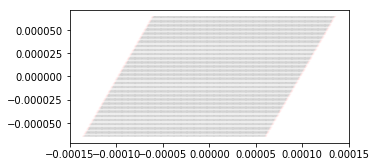

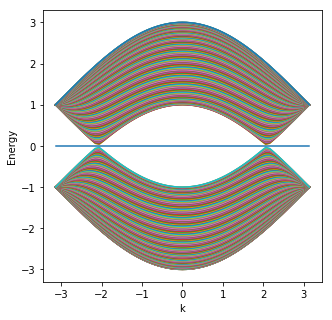

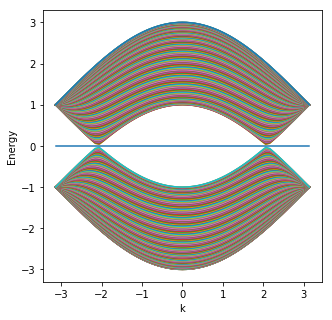

In [133]:
a0 = 0.142e-9
a = 1e-6
W = 130e-6
L = 120e-6
t = 1
w = 10e-6
pot = 0.8
Ef = 0.2
sys = make_system(a,W,L,t)

kwant.plot(sys,site_size=1e-6)

# Finalize the system.
sys = sys.finalized()
kwant.plotter.bands(sys.leads[0])

In [111]:
B_eff = 0.0
#phi = B * 3*np.sqrt(3)/(2)*alat**2

In [112]:
params = SimpleNamespace(phi=phi)#, Vg=Vg, l_pot=l_pot, w_pot=w_pot, R=R, shape=shape)

In [124]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 3 * pi * a * t / Ef # computation of the wavelength in graphene
print('Fermi wavelength: ', lambda_F)
if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')

Fermi wavelength:  47.12388980384689


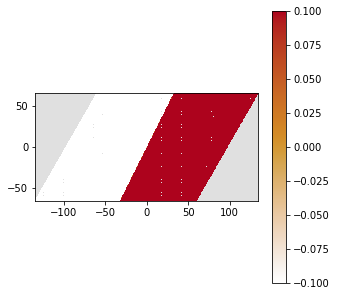

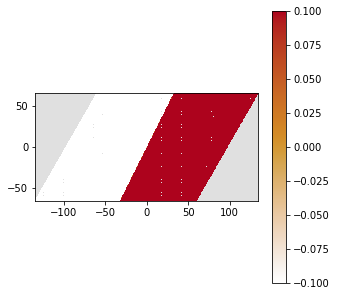

In [122]:
vals=[onsite(sys.sites[n]) for n in range(sys.graph.num_nodes)]
kwant.plotter.map(sys, vals)

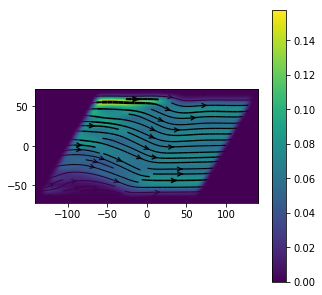

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


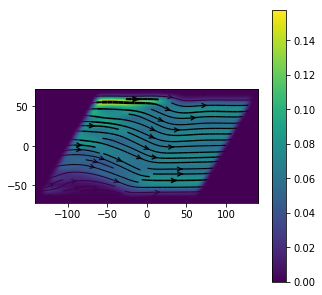

In [123]:
wfs = kwant.wave_function(sys, energy=Ef) # to obtain the wave functions of the system 

J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
current = sum(J0(p) for p in wf_left)

kwant.plotter.current(sys, current, cmap='viridis')

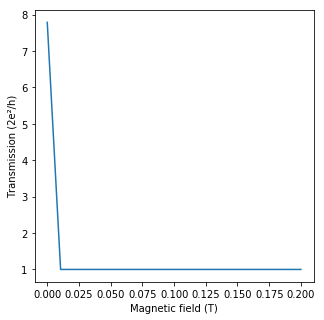

In [125]:
N = 20 # number of magnetic field values
B_eff_max = 0.2 # higher magnetic field
B_effs = np.linspace(0, B_eff_max, N) # vector of the magnetic fields

G = np.zeros([N,1])

for i,B_eff in enumerate(B_effs):
    params = SimpleNamespace(B_eff=B_eff)
    smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
    T = smatrix.transmission(1, 0) # transmission value obtained from the left lead towards the right lead
    G[i] = T
    
plt.plot(B_effs,G)

plt.xlabel('Magnetic field (T)')
plt.ylabel('Transmission (2e²/h)')

plt.show()

Effective magnetic field :  0.0


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 0.72% of values overflowing upper limit 0.470668 
  # Remove the CWD from sys.path while we load stuff.


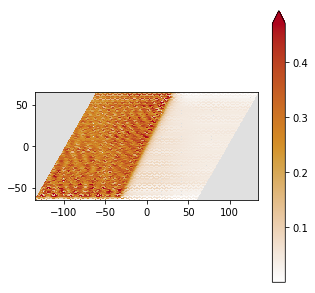

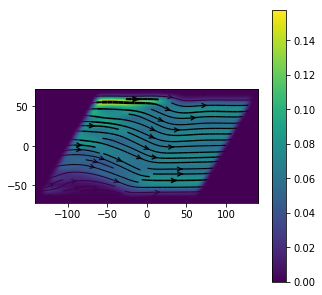

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.010526315789473684


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 0.80% of values overflowing upper limit 0.457267 
  # Remove the CWD from sys.path while we load stuff.


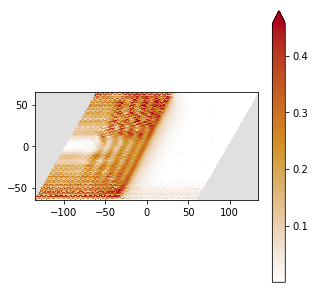

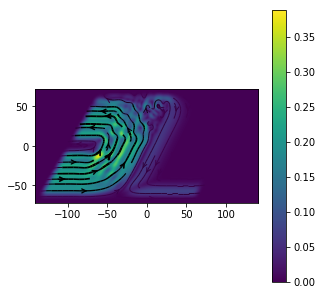

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.021052631578947368


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.21% of values overflowing upper limit 0.335983 
  # Remove the CWD from sys.path while we load stuff.


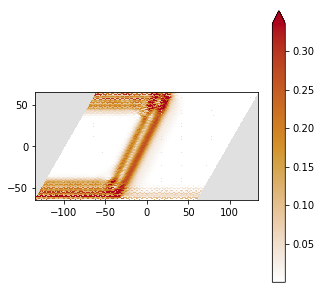

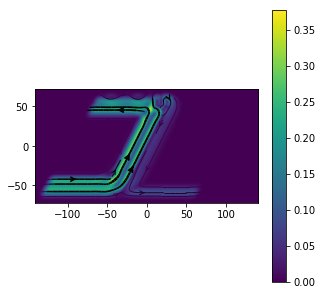

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.031578947368421054


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.07% of values overflowing upper limit 0.310514 
  # Remove the CWD from sys.path while we load stuff.


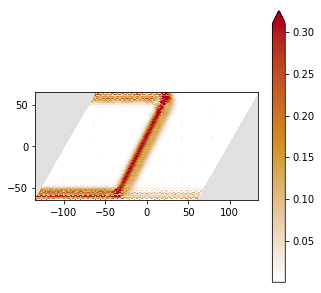

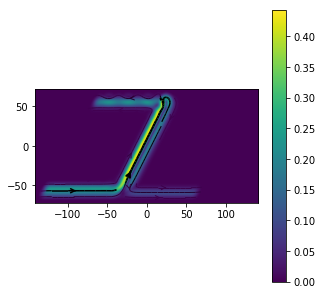

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.042105263157894736


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.22% of values overflowing upper limit 0.360602 
  # Remove the CWD from sys.path while we load stuff.


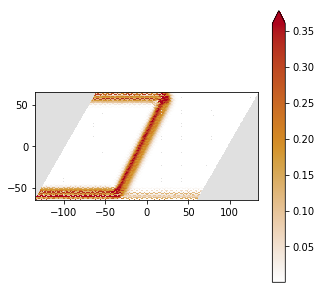

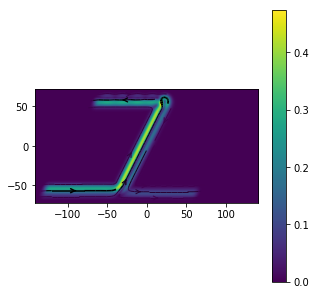

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.05263157894736842


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.05% of values overflowing upper limit 0.577168 
  # Remove the CWD from sys.path while we load stuff.


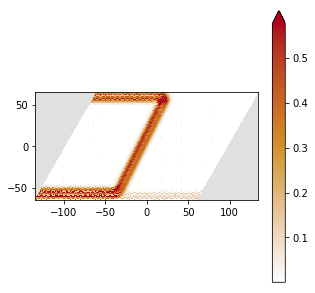

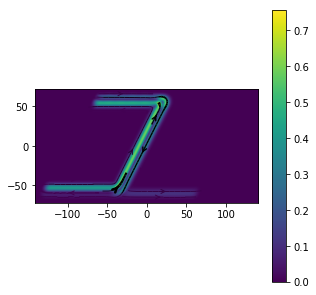

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.06315789473684211


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.30% of values overflowing upper limit 0.15799 
  # Remove the CWD from sys.path while we load stuff.


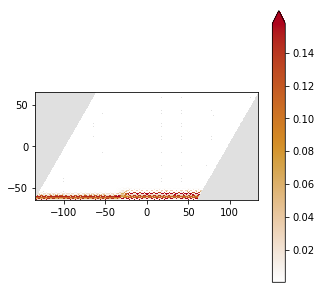

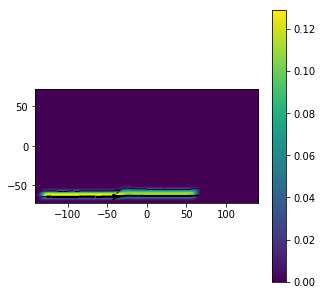

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.07368421052631578


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.57% of values overflowing upper limit 0.165247 
  # Remove the CWD from sys.path while we load stuff.


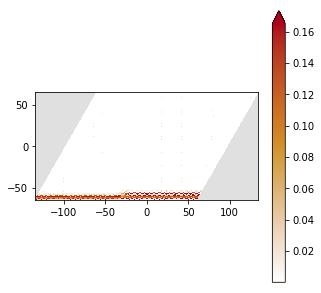

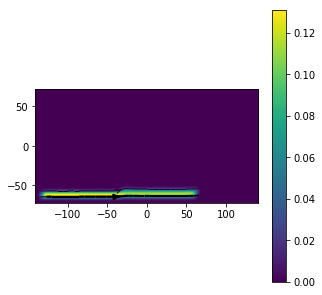

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.08421052631578947


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.58% of values overflowing upper limit 0.169847 
  # Remove the CWD from sys.path while we load stuff.


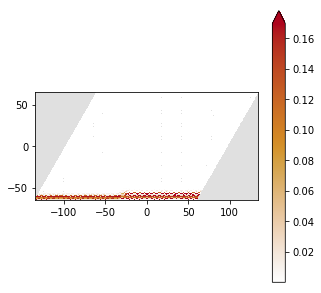

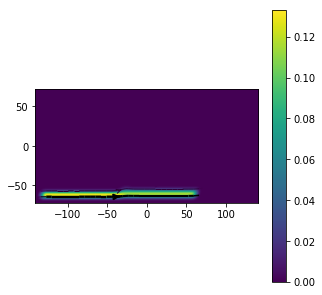

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Effective magnetic field :  0.09473684210526316


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.56% of values overflowing upper limit 0.185943 
  # Remove the CWD from sys.path while we load stuff.


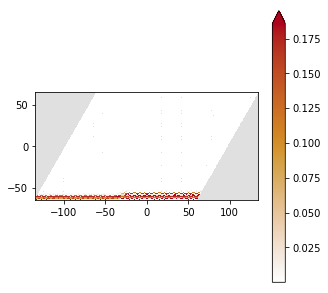

KeyboardInterrupt: 

In [126]:
N = 20
B_eff_max = 0.2 # higher magnetic field
B_effs = np.linspace(0, B_eff_max, N) # vector of the magnetic fields
for B_eff in B_effs:
    print('Effective magnetic field : ', B_eff)
    phi = B_eff * a
    params = SimpleNamespace(B_eff=B_eff)
    wfs = kwant.wave_function(sys, energy=Ef)
    scattering_wf = wfs(0)  # all scattering wave functions from lead 0
    kwant.plotter.map(sys, np.sum(abs(scattering_wf)**2, axis=0));
    
    wf_left = wfs(0)
    current = sum(J0(p) for p in wf_left) # to sum over all the lead's mode
    kwant.plotter.current(sys, current, cmap='viridis')

In [9]:
N = 50
E = np.linspace(-1.5,1.5,N)
Gr = np.zeros([N,1])
for i,Ef in enumerate(E):
    smatrix = kwant.smatrix(graph, energy = Ef)
    T = smatrix.transmission(1, 0)
    Gr[i] = T

Text(0, 0.5, 'Transmission')

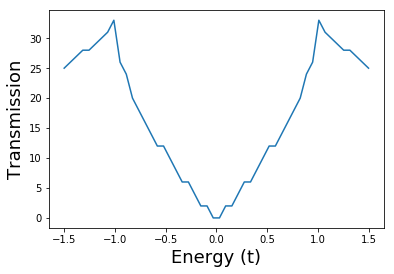

In [10]:
pyplot.plot(E,Gr)

pyplot.xlabel('Energy (t)', fontsize=18)
pyplot.ylabel('Transmission', fontsize=18)